In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
variables_eliminar="""funded_amnt_inv
grade
sub_grade
préstamo 
emp_title
verification_status
purpose
zip_code
addr_state
dti
delinq_2yrs
inq_last_6mths
revol_bal
revol_util
total_acc
out_prncp
out_prncp_inv
out_prncp_inv
total_pymnt
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_amnt
last_credit_pull_d
collections_12_mths_ex_med
policy_code
tot_coll_amt
total_rev_hi_lim"""
variables_eliminar=np.array(variables_eliminar.replace(" ", "").split("\n"))
variables_eliminar.shape=(5,6)
variables_eliminar=pd.DataFrame(variables_eliminar)
variables_eliminar.columns=[" "]*6
variables="""__loan_amnt__:El monto indicado del préstamo solicitado por el prestatario. Si en algún momento, el departamento de crédito reduce el monto del préstamo, entonces se reflejará en este valor.

__funded_amnt__: El monto total comprometido con ese préstamo en ese momento.

__term__: El número de pagos del préstamo. Los valores son en meses y pueden ser 36 o 60.

__int_rate__: tasa de interés del préstamo.

__installment__:cuota El pago mensual adeudado por el prestatario si el préstamo se origina.

__emp_length__: años trabajo

__home_ownership__: El estado de propiedad de la vivienda proporcionado por el prestatario durante el registro. Nuestros valores son: ALQUILER, PROPIEDAD, HIPOTECA, OTRO.

__annual_inc__: Los ingresos anuales autoinformados proporcionados por el prestatario durante el registro.

__pymnt_plan__: indica si se a establecido un plan de pago.

__earliest_cr_line__: El mes en que se abrió la primera línea de crédito reportada del prestatario.

__open_acc__: El número de líneas de crédito abiertas en el archivo de crédito del prestatario.

__pub_rec__: numero de derogatory public records.

__initial_list_status__: El estado inicial de listado del préstamo. Los valores posibles son – W, F

__acc_now_delinq__:El número de cuentas en las que el prestatario está ahora en mora.

__purpose__: fdfgsf

__tot_cur_bal__:Saldo corriente total de todas las cuentas
""".split("\n")
#.replace("__","")
variables=pd.Series(variables)
variables_= variables[~(variables=="")].apply(lambda x: x.split(":")[0])
descripcion_=variables[~(variables=="")].apply(lambda x: x.split(":")[1])
result=pd.DataFrame({"Variables": variables_, "Descripción":descripcion_ })
result=result.reset_index()
variables_=pd.Series(variables_).apply(lambda x: x.replace("__","" ))

In [3]:
df=pd.read_csv('loan_data_2007_2014.csv')

C:\Users\German\AppData\Local\Temp\ipykernel_10388\3755368906.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('loan_data_2007_2014.csv')


In [4]:
drop_columns=["id", "member_id", "url", "title"]
df=df.drop(labels=drop_columns,axis=1 )
total_na=df.isna().sum()
filtro=total_na< df.shape[0]*0.2
total_na=total_na[filtro]
result=pd.DataFrame({"Variables":["Menos del 20% NA"," Mas del 20% NA"],
"Total":[total_na.shape[0], 70-total_na.shape[0] ]} )
#print(result.to_markdown(index=False,tablefmt="grid",numalign="center",stralign ="center",floatfmt=".0f"))
result

,Variables,Total
0,Menos del 20% NA,48
1,Mas del 20% NA,22


In [5]:
table_frec=pd.DataFrame(df["loan_status"].value_counts())
status_mora=['Charged Off', 'Default', 'Late (31-120 days)','Does not meet the credit policy. Status:Charged Off']
table_frec["good_status"]=1
filtro=pd.Series(table_frec.index).isin( status_mora)
table_frec.loc[list(filtro), "good_status"]=0
table_frec=table_frec.reset_index()
table_frec.columns=["loan_status", "Frec", "good_status" ]
table_frec[["loan_status", "good_status","Frec" ]]

,loan_status,good_status,Frec
0,Current,1,224226
1,Fully Paid,1,184739
2,Charged Off,0,42475
3,Late (31-120 days),0,6900
4,In Grace Period,1,3146
5,Does not meet the credit policy. Status:Fully ...,1,1988
6,Late (16-30 days),1,1218
7,Default,0,832
8,Does not meet the credit policy. Status:Charge...,0,761


In [6]:
status_mora=['Charged Off', 'Default', 'Late (31-120 days)','Does not meet the credit policy. Status:Charged Off']
df['issue_d']=pd.to_datetime(df['issue_d'], format = "%b-%y")
df['last_pymnt_d']=pd.to_datetime(df['last_pymnt_d'], format = "%b-%y")
df["month_last"]= ((df.last_pymnt_d - df.issue_d)/np.timedelta64(1, 'M'))
df['target_time']=0
df.loc[df["month_last"]<=12,'target_time']=1
df["good_status"]=1
df.loc[df["loan_status"].isin(status_mora),"good_status"]=0
df=df[ [*variables_, "good_status","target_time" ]] 
df=df[~df.isna().any(axis=1)]

In [7]:
tabla_1=df.good_status.value_counts(normalize=True)*100
tabla_2=df.good_status.value_counts()
tabla_3=df.target_time.value_counts(normalize=True)*100
tabla_4=df.target_time.value_counts()
table_final=pd.DataFrame({"good status":[1,0],"Frecuencia":tabla_2, 
                          "Frec %":tabla_1, "target time":[0,1],
                         "Frecuencia ":tabla_4, "Frec % ":tabla_3 } )

In [9]:
from scipy.stats import chi2_contingency
X=df.drop(labels="good_status",axis=1)
Y=df["good_status"]

X_train_cat = X.select_dtypes(include = 'object').copy()
X_train_num = X.select_dtypes(include = 'number').copy()
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(Y, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)


,Feature,p-value
0,term,0.000000
1,emp_length,0.000000
2,home_ownership,0.000000
3,earliest_cr_line,0.000000
4,initial_list_status,0.000000
5,purpose,0.000000
6,pymnt_plan,0.136062
7,application_type,1.000000


<AxesSubplot:>

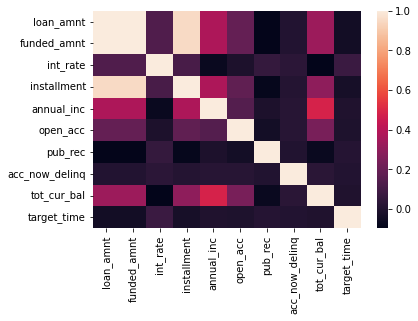

In [12]:
import matplotlib.pyplot as plt
corrmat = X_train_num.corr()
# plt.figure(figsize=(10,10))
sns.heatmap(corrmat)

In [27]:
df.acc_now_delinq.value_counts()

0.0    375407
1.0      1551
2.0        87
3.0        11
4.0         4
5.0         2
Name: acc_now_delinq, dtype: int64

<AxesSubplot:xlabel='good_status', ylabel='tot_cur_bal'>

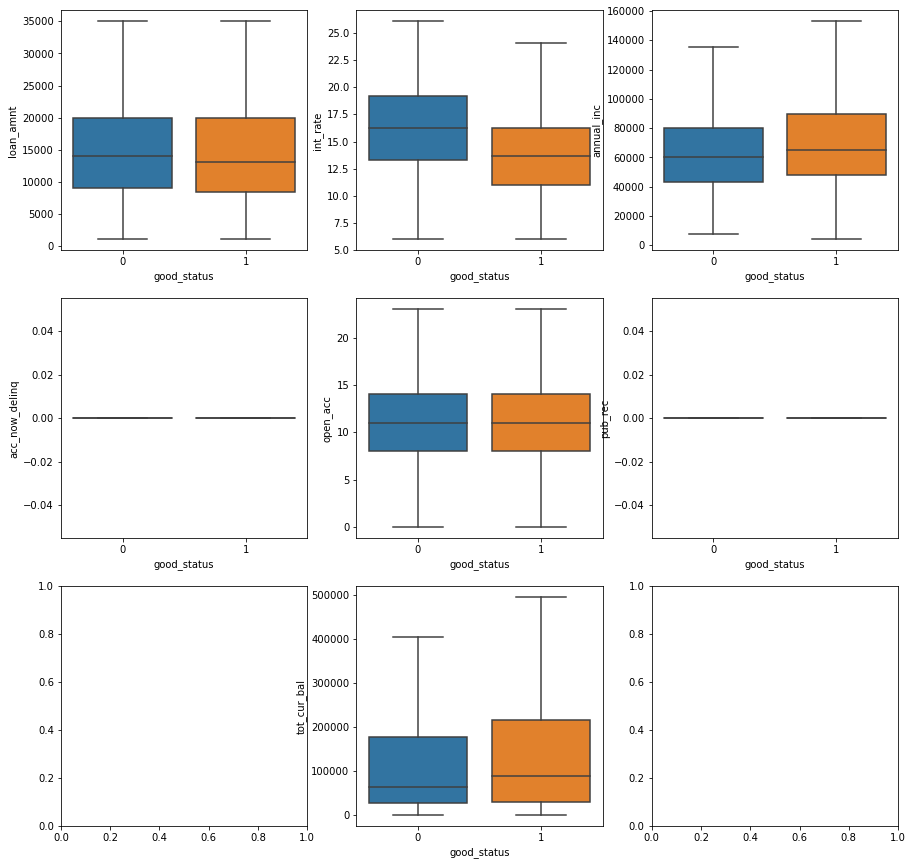

In [26]:
vars_=['loan_amnt',  'int_rate',  'annual_inc',
       'open_acc', 'pub_rec', 'acc_now_delinq', 'tot_cur_bal']
fig, axs = plt.subplots(ncols=3,nrows=3,figsize=(15, 15))
sns.boxplot(data=df, x="good_status", y=vars_[0], ax=axs[0, 0],showfliers = False)
sns.boxplot(data=df, x="good_status", y=vars_[1], ax=axs[0, 1],showfliers = False)
sns.boxplot(data=df, x="good_status", y=vars_[2], ax=axs[0, 2],showfliers = False)
sns.boxplot(data=df, x="good_status", y=vars_[3], ax=axs[1, 1],showfliers = False)
sns.boxplot(data=df, x="good_status", y=vars_[4], ax=axs[1, 2],showfliers = False)
sns.boxplot(data=df, x="good_status", y=vars_[5], ax=axs[1, 0],showfliers = False)
sns.boxplot(data=df, x="good_status", y=vars_[6], ax=axs[2, 1],showfliers = False)
